<div class="alert alert-block alert-info">
<b>Note:</b> The goal of this notebook is to show you how to work with the Bayesian Statistics Toolbox (BST) when performing an analysis that involves comparing the effect of multiple nominal predictors on a metric outcome (think two-way and mixed-model ANOVAs) that may be normally or non-normally distributed (the "robust" version). These models utilize multi-level (hierarchical) modeling, one of the great strengths of Bayesian modeling. This is an adaptation of Jordi Warmenhoven's PyMC3 port of Chapter 20 of John Kruschke's textbook "Doing Bayesian Data Analysis: A Tutorial with R, JAGS, and Stan" (https://github.com/JWarmenhoven/DBDA-python). Please note that the code has been updated to make use of PyMC4 and that this does not (yet) include all of the examples from the original. </div>

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr
import aesara.tensor as at

import src.bayesian_stats as bst

from IPython.display import Image

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.3.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.95

## 20.2 Hierarchical Bayesian Approach

In [3]:
df = pd.read_csv('data/Salary.csv', usecols=[0,3,5], dtype={'Org': 'category', 'Pos': 'category'})
df.head()

# Reorder the Pos categories and rename categories
df.Pos.cat.reorder_categories(['FT3', 'FT2', 'FT1', 'NDW', 'DST'], ordered=True, inplace=True)
df.Pos.cat.rename_categories(['Assis', 'Assoc', 'Full', 'Endow', 'Disting'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Org     1080 non-null   category
 1   Pos     1080 non-null   category
 2   Salary  1080 non-null   int64   
dtypes: category(2), int64(1)
memory usage: 13.4 KB


/var/folders/42/fy648srd41l966jbjlswhljc0000gn/T/ipykernel_9351/3298544577.py:5: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df.Pos.cat.reorder_categories(['FT3', 'FT2', 'FT1', 'NDW', 'DST'], ordered=True, inplace=True)
/var/folders/42/fy648srd41l966jbjlswhljc0000gn/T/ipykernel_9351/3298544577.py:6: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df.Pos.cat.rename_categories(['Assis', 'Assoc', 'Full', 'Endow', 'Disting'], inplace=True)


In [4]:
df.groupby('Pos').apply(lambda x: x.head(2))

Org      Pos  Salary
Pos                               
Assis   4    LGED    Assis   63796
        6    INFO    Assis   98814
Assoc   0      PL    Assoc   72395
        1    MUTH    Assoc   61017
Full    7    CRIN     Full  107745
        9     PSY     Full  173302
Endow   5    MGMT    Endow  219600
        8    CRIN    Endow  114275
Disting 29   SPEA  Disting  285000
        128  MUHI  Disting  114189

### Kruschke-style graphical model

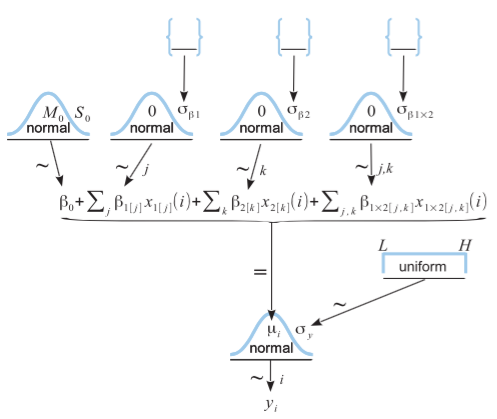

In [5]:
Image('images/fig20_2.png')

In [6]:
# Data wrangling
y = df.Salary
mu_y = y.mean()
sigma_y = y.std()

x1 = df.Pos
x2 = df.Org

x1_vals, levels_x1, n_levels_x1 = bst.parse_categorical(x1)
x2_vals, levels_x2, n_levels_x2 = bst.parse_categorical(x2)

In [7]:
# Call your BST function
model1, idata1 = bst.bayesian_two_factor_anova(x1, x2, y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0_tilde, sigma_a1, a1_tilde, sigma_a2, a2_tilde, sigma_a1a2, a1a2_tilde, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 490 seconds.


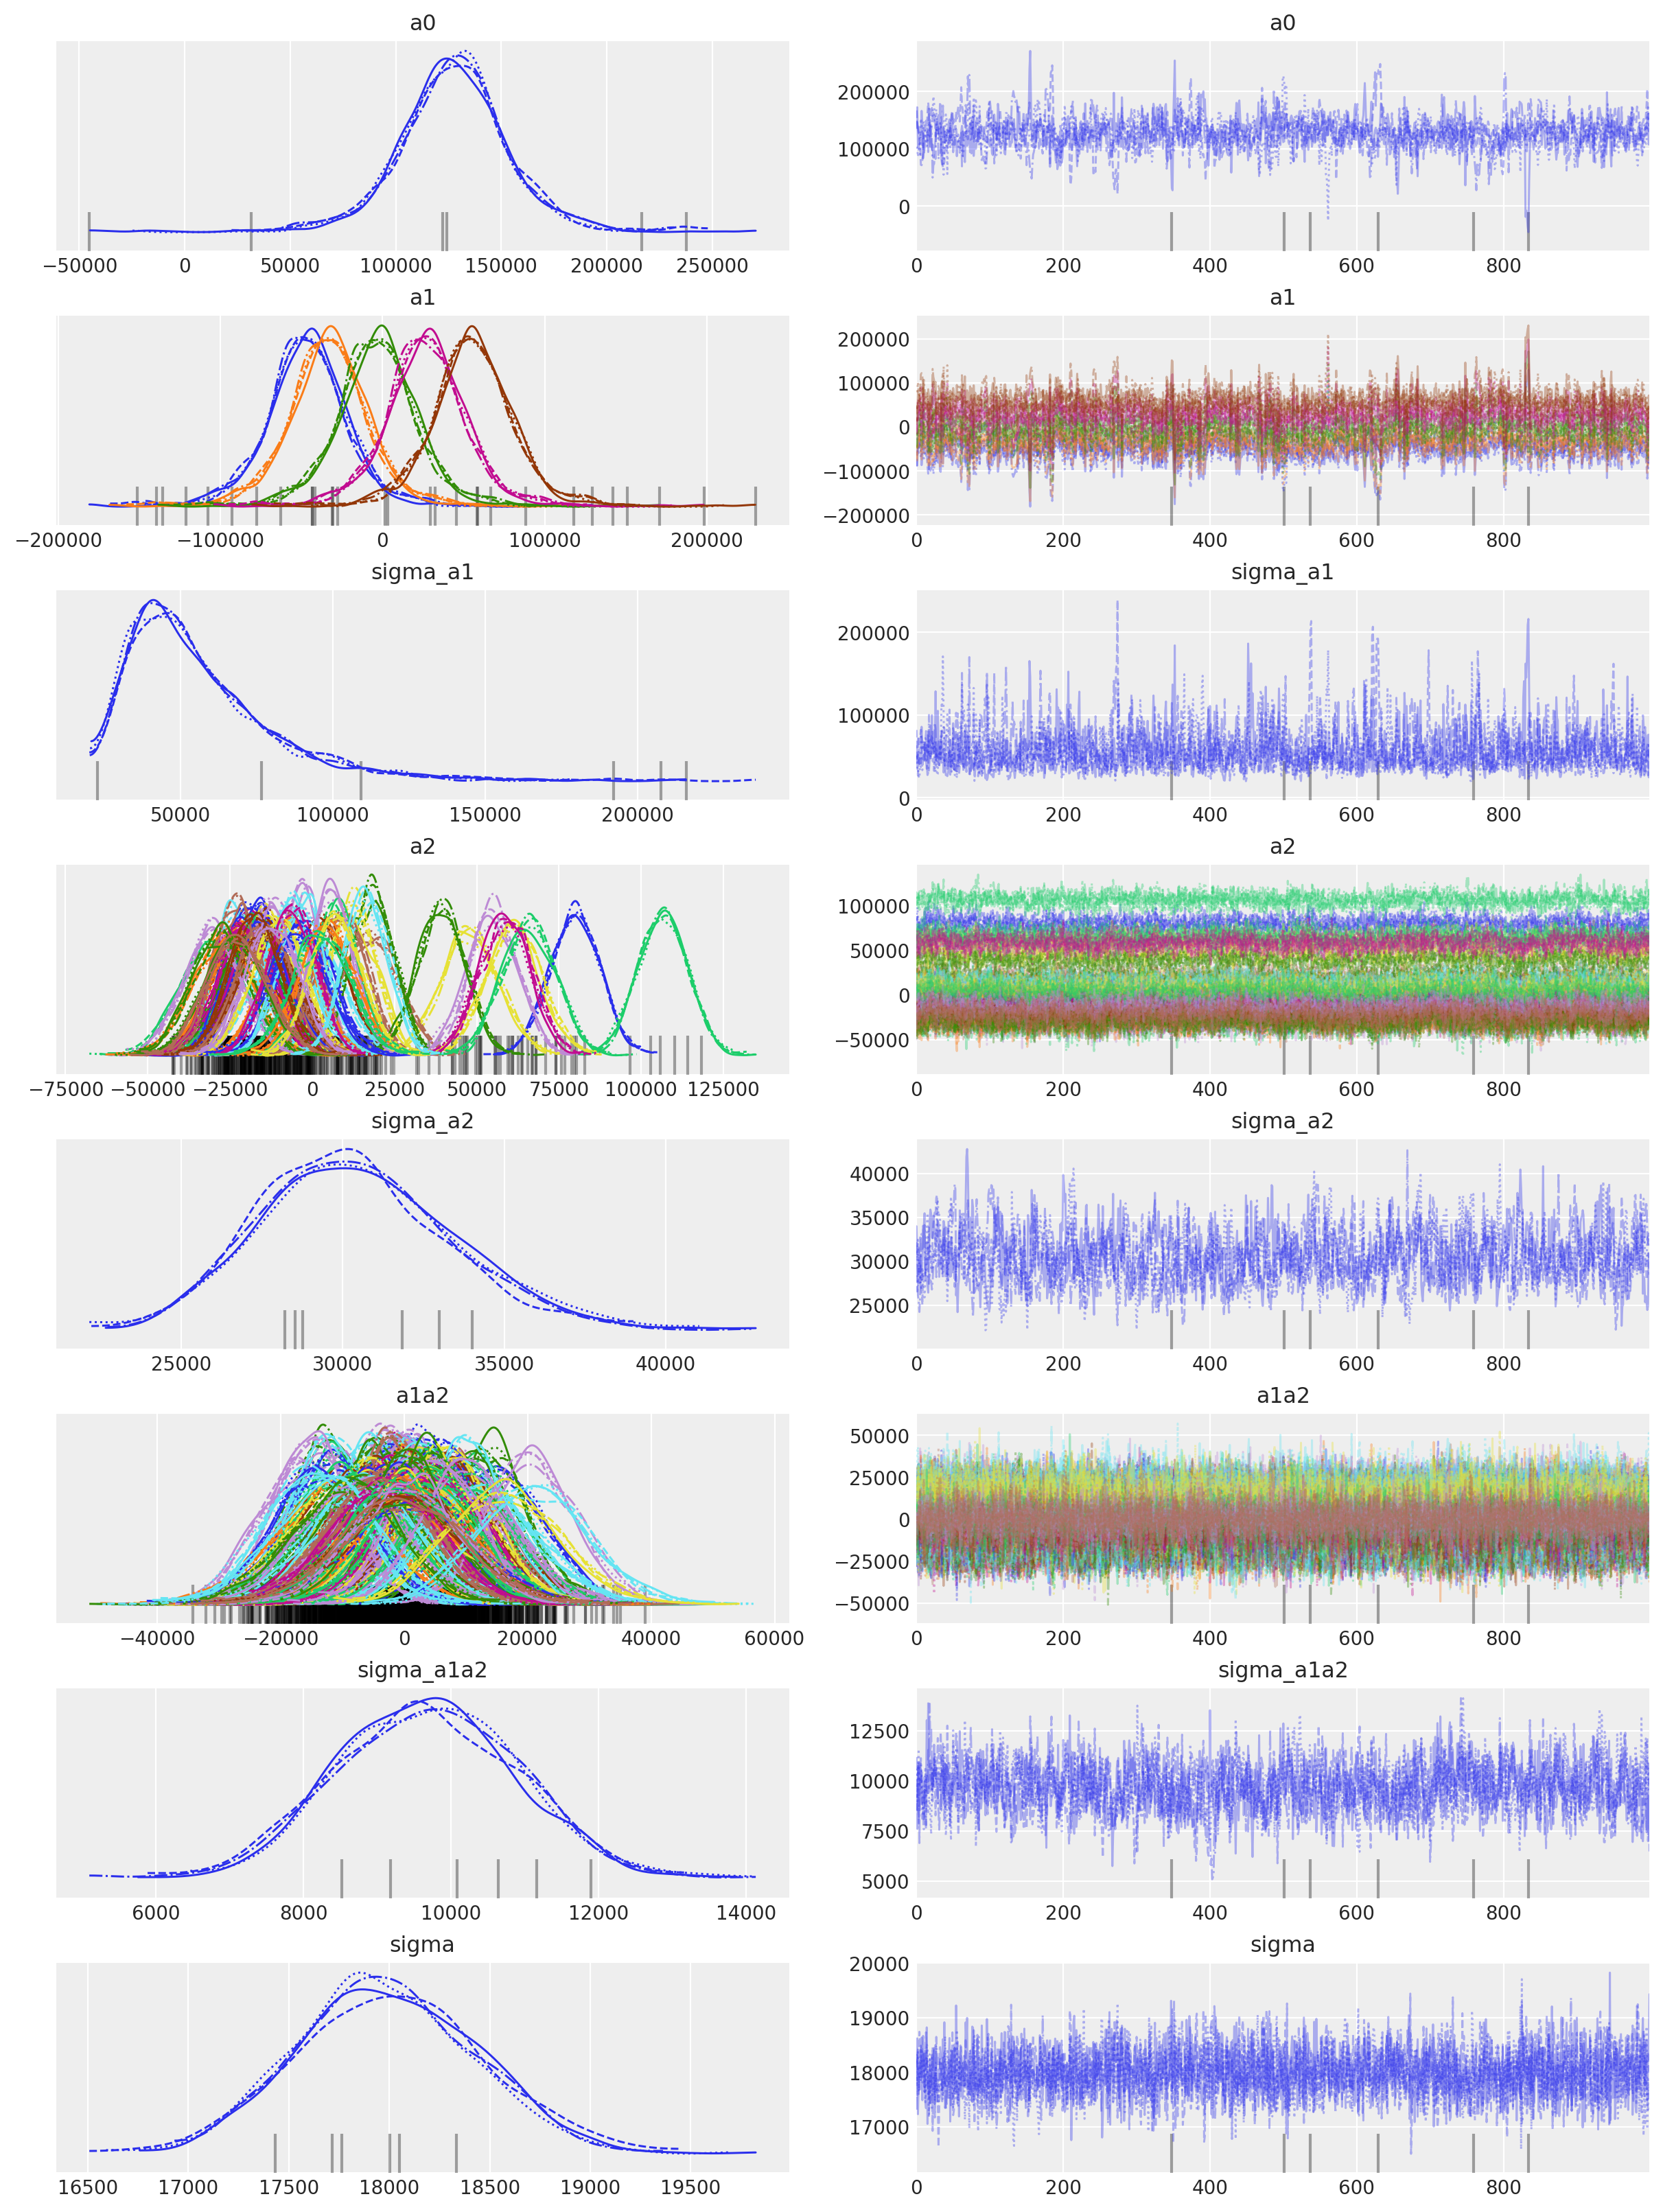

In [8]:
# Plot marginal posteriors and check the health of your chains
pm.plot_trace(idata1, var_names=['a0', 'a1', 'sigma_a1', 'a2', 'sigma_a2', 'a1a2', 'sigma_a1a2', 'sigma']);

In [18]:
# Convert coefficients to sum-to-zero deflections
post = two_factor_anova_convert_to_sum_to_zero(idata1, x1, x2)
post = post.rename({"factor1": "rank", "factor2": "dept"})
post

<xarray.Dataset>
Dimensions:     (rank: 5, dept: 60, a1_dim_0: 5, a2_dim_0: 60, a1a2_dim_0: 5,
                 a1a2_dim_1: 60, sample: 4000)
Coordinates:
  * rank        (rank) <U7 'Assis' 'Assoc' 'Full' 'Endow' 'Disting'
  * dept        (dept) <U4 'ACTG' 'AFRO' 'AMST' 'ANTH' ... 'STAT' 'TELC' 'THTR'
  * a1_dim_0    (a1_dim_0) int64 0 1 2 3 4
  * a2_dim_0    (a2_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 52 53 54 55 56 57 58 59
  * a1a2_dim_0  (a1a2_dim_0) int64 0 1 2 3 4
  * a1a2_dim_1  (a1a2_dim_1) int64 0 1 2 3 4 5 6 7 8 ... 52 53 54 55 56 57 58 59
  * sample      (sample) object MultiIndex
  * chain       (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw        (sample) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables: (12/17)
    a0_tilde    (sample) float64 0.1208 0.2808 -0.03328 ... 0.0951 0.08856
    a1_tilde    (rank, sample) float64 -1.321 -1.757 -0.4909 ... 0.8701 0.9376
    a2_tilde    (dept, sample) float64 2.155 2.867 2.583 ... -0.5408 -0.5193
    a1a2_tilde  (rank, dept, sample) float64 2.894 0.6667 ... -0.2892 -0.3197
    sigma_a1    (sample) float64 4.596e+04 4.986e+04 ... 5.137e+04 5e+04
    sigma_a2    (sample) float64 3.4e+04 3.045e+04 ... 3.207e+04 3.252e+04
    ...          ...
    a1a2        (a1a2_dim_0, a1a2_dim_1, sample) float64 2.411e+04 ... -3.207...
    m           (rank, dept, sample) float64 1.739e+05 1.774e+05 ... 1.568e+05
    b1b2        (rank, dept, sample) float64 1.268e+04 1.002e+04 ... -2.561e+03
    b0          (sample) float64 1.281e+05 1.277e+05 ... 1.257e+05 1.258e+05
    b1          (rank, sample) float64 -4.77e+04 -4.604e+04 ... 5.081e+04
    b2          (dept, sample) float64 8.075e+04 8.574e+04 ... -1.716e+04
Attributes:
    created_at:                 2022-11-20T15:57:29.261072
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0
    sampling_time:              490.186585187912
    tuning_steps:               1000

### 20.2.3 - Main effect contrasts

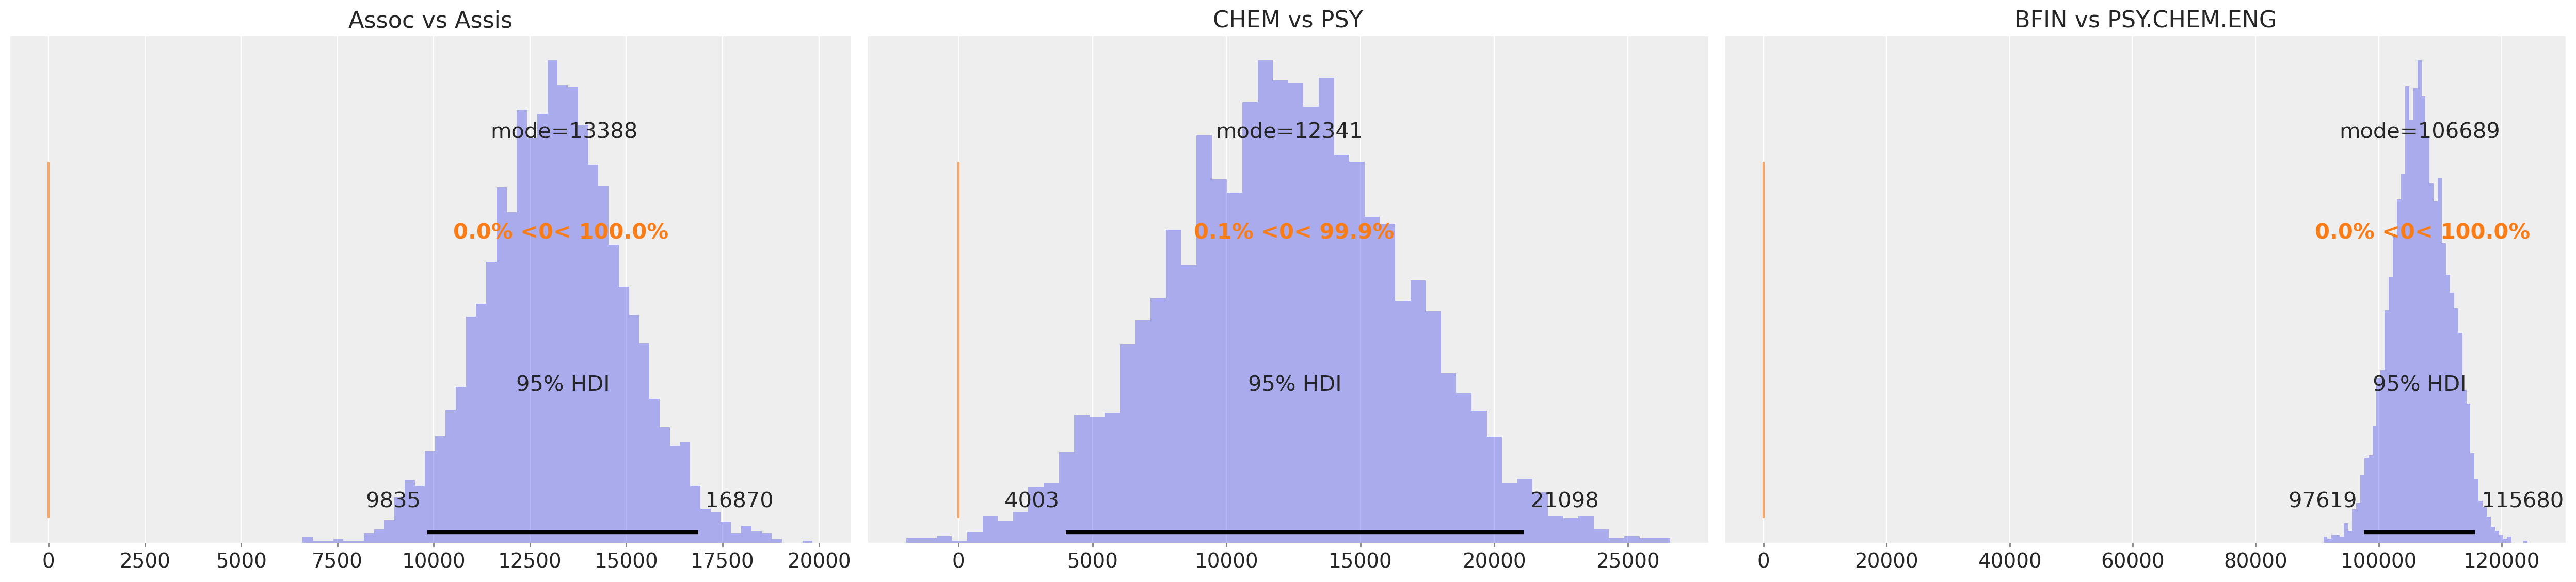

In [19]:
# Create a dict of contrasts using label-based indexing
contrasts = {"Assoc vs Assis": post.b1.sel(rank="Assoc") - post.b1.sel(rank="Assis"),
            "CHEM vs PSY": post.b2.sel(dept="CHEM") - post.b2.sel(dept="PSY"),
            "BFIN vs PSY.CHEM.ENG": post.b2.sel(dept="BFIN") - post.b2.sel(dept=["PSY", "CHEM", "ENG"]).mean()}
az.plot_posterior(contrasts, kind="hist", bins=50, point_estimate="mode", ref_val=0);


### 20.2.4 - Interaction contrasts and simple effects

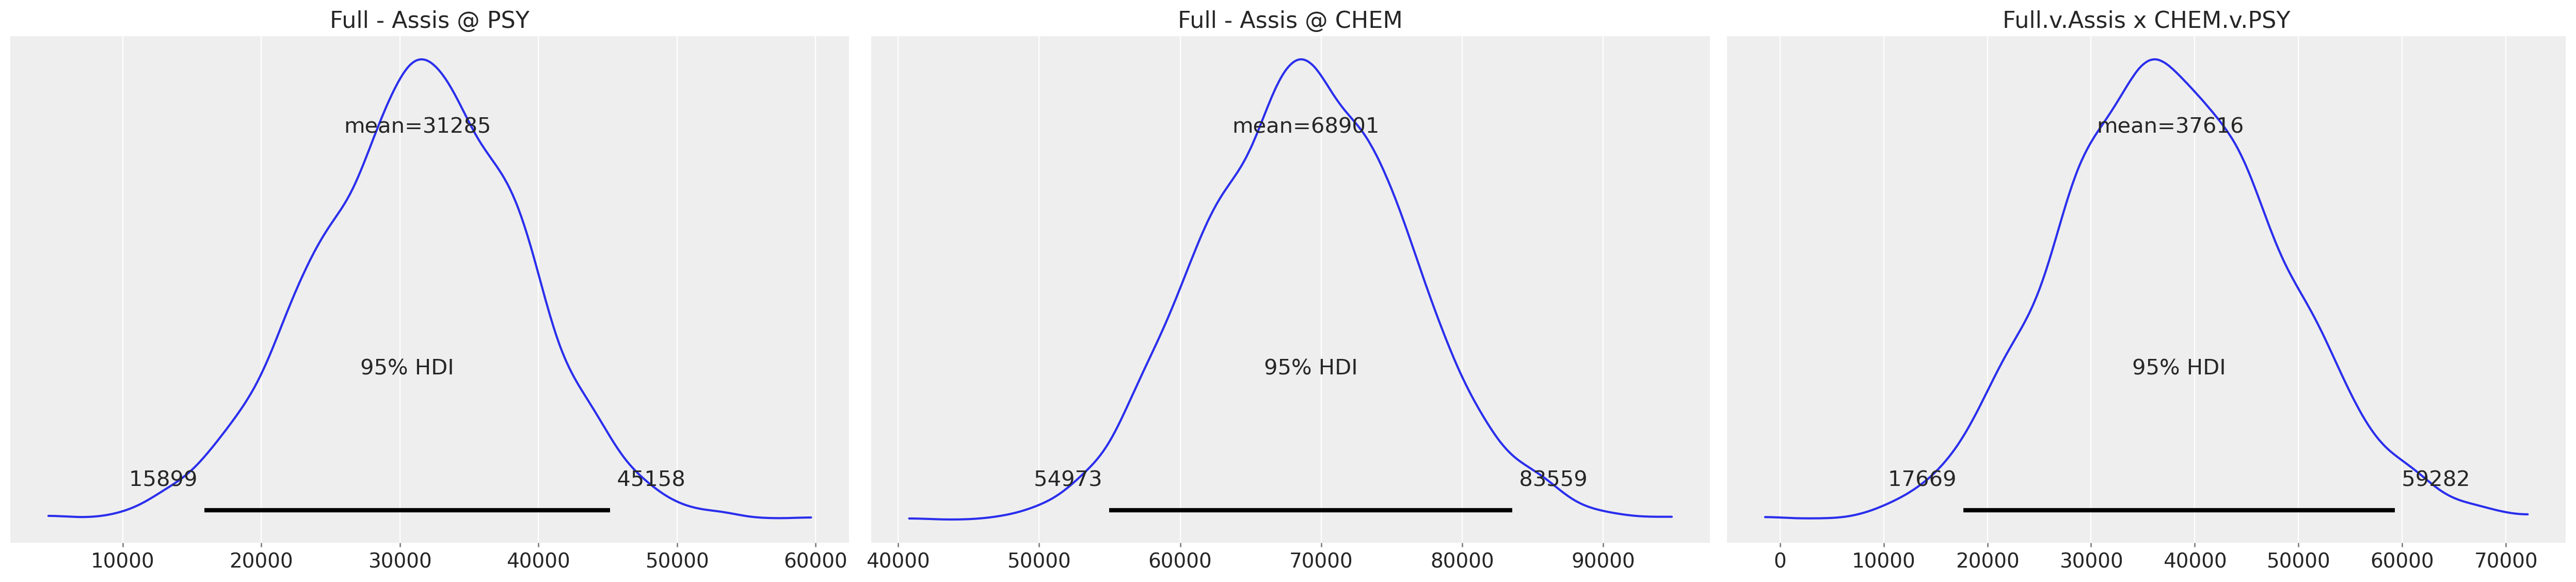

In [20]:
interactions = {"Full - Assis @ PSY": post.m.sel(rank="Full", dept="PSY") - post.m.sel(rank="Assis", dept="PSY"),
                "Full - Assis @ CHEM": post.m.sel(rank="Full", dept="CHEM") - post.m.sel(rank="Assis", dept="CHEM"),
               "Full.v.Assis x CHEM.v.PSY": 
                (post.b1b2.sel(rank="Full", dept="CHEM") - post.b1b2.sel(rank="Assis", dept="CHEM") - 
                (post.b1b2.sel(rank="Full", dept="PSY") - post.b1b2.sel(rank="Assis", dept="PSY")))}
az.plot_posterior(interactions, combine_dims={"sample"});


### Split-plot design

In [21]:
df2 = pd.read_csv('data/SplitPlotAgriData.csv')
df2.info()

# Between-subjects factor (i.e., group)
x_between, levels_x_between, num_levels_x_between = bst.parse_categorical(df2.Till)

# Within-subjects factor (i.e., target set)
x_within, levels_x_within, num_levels_x_within = bst.parse_categorical(df2.Fert)

# Individual subjects
x_subj, levels_x_subj, num_levels_x_subj = bst.parse_categorical(df2.Field)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Field   99 non-null     int64 
 1   Till    99 non-null     object
 2   Fert    99 non-null     object
 3   Yield   99 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ KB


In [22]:
df2.head()

Field    Till     Fert  Yield
0      1  Chisel    Broad    119
1      1  Chisel     Deep    130
2      1  Chisel  Surface    123
3      2  Chisel    Broad    135
4      2  Chisel     Deep    148

/Users/hyosubkim/opt/anaconda3/envs/bayes_toolbox/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


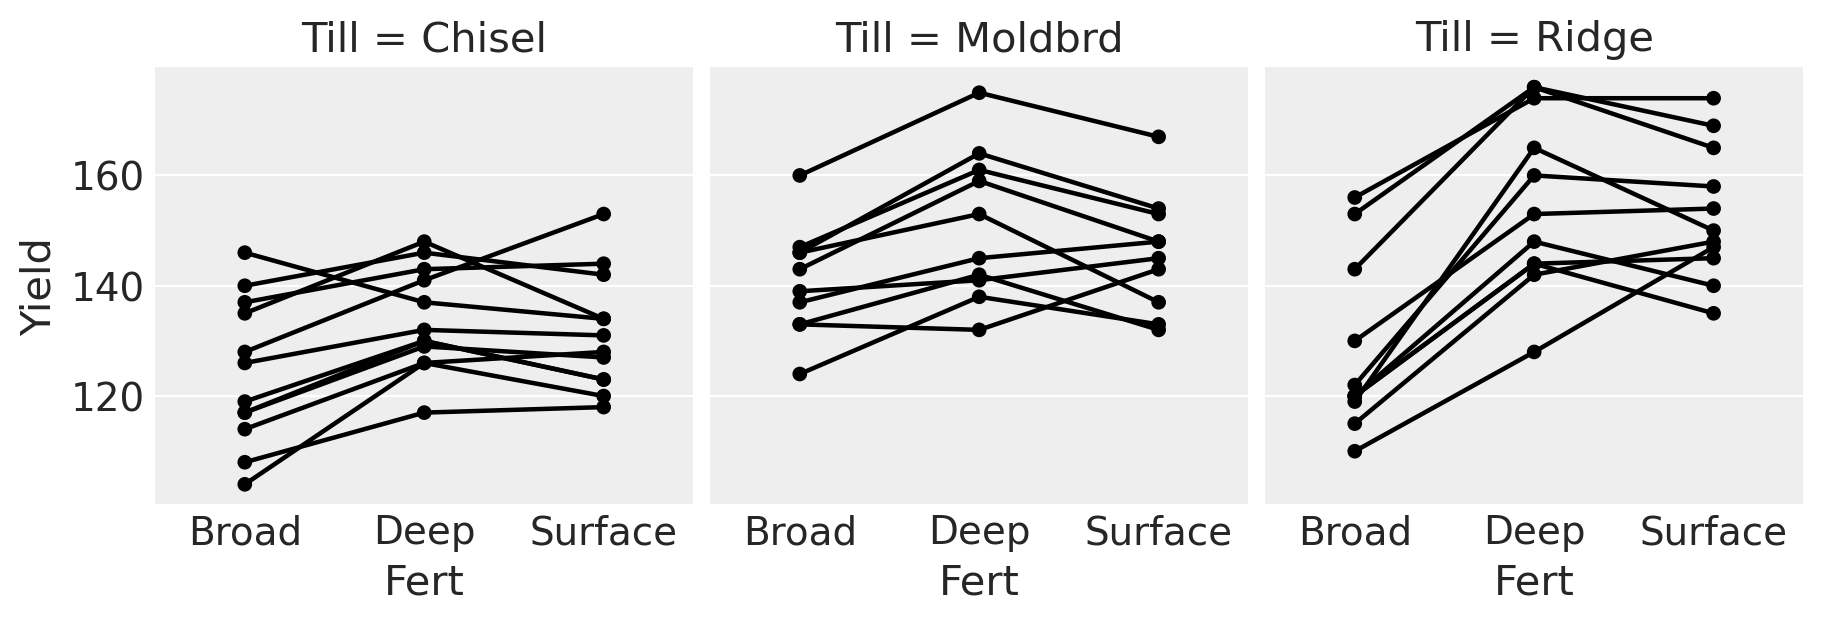

In [23]:
# Plot the data
g = sns.FacetGrid(df2, col='Till', hue='Field')
g.map(sns.pointplot, 'Fert', 'Yield', color='k', scale=0.6);

In [24]:
# Fit your model
model2, idata2 = bst.mixed_model_anova(df2.Till, df2.Fert, df2.Field, df2.Yield)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, sigma_B, aB, sigma_W, aW, sigma_BxW, aBxW, sigma_S, aS, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 237 seconds.


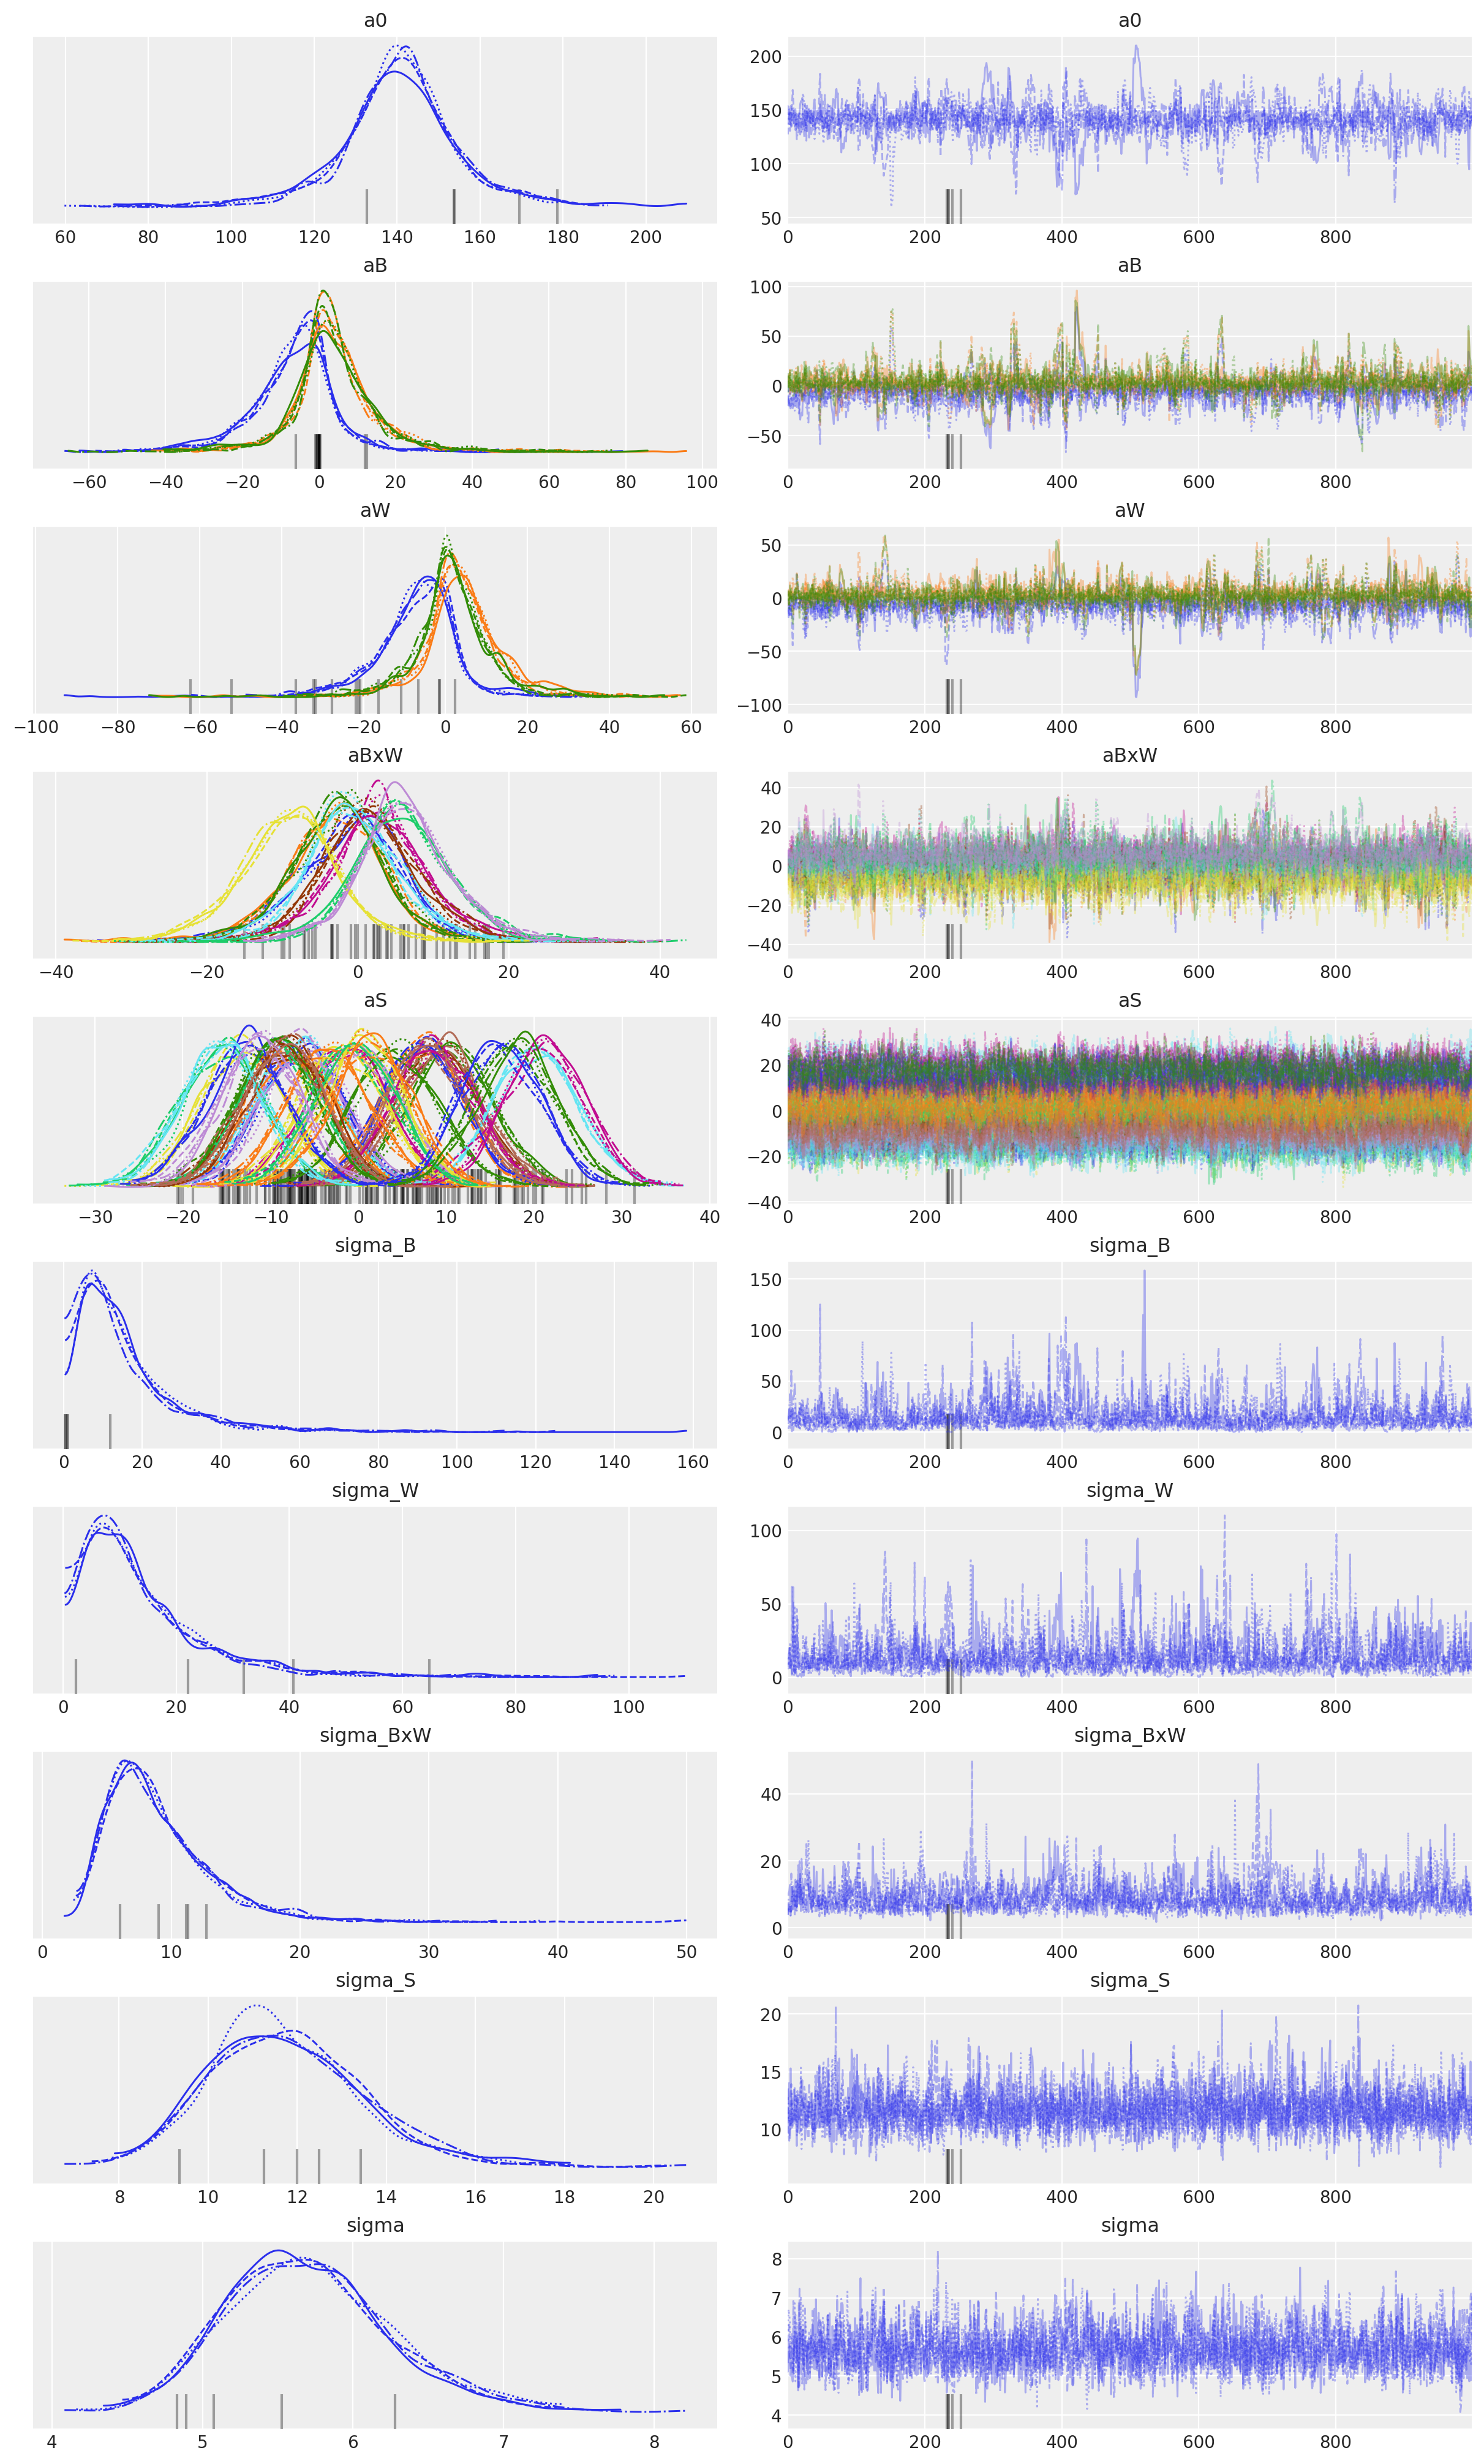

In [25]:
# Plot marginal posteriors and check the health of your chains
az.plot_trace(idata2);

In [26]:
# Now return the parameters back to the raw scale
b0, bB, bW, bBxW, bS = bst.convert_to_sum_to_zero(idata2, df2.Till, df2.Fert, df2.Field) 

In [27]:
print('Mean baseline yield: {}'.format(b0.values.mean()))

Mean baseline yield: 140.41343215144164


In [28]:
print('Mean yield deflection from baseline for tilling method:')
pd.DataFrame(bB.mean(dim="sample"), index=levels_x_between, columns=['Deflection'])

Mean yield deflection from baseline for tilling method:


Deflection
Chisel   -10.562150
Moldbrd    5.474761
Ridge      5.087389

In [29]:
print('Mean yield deflection from baseline for fertilization method:')
pd.DataFrame(bW.mean(dim="sample"), index=levels_x_within, columns=['Deflection'])

Mean yield deflection from baseline for fertilization method:


Deflection
Broad     -9.291714
Deep       6.225766
Surface    3.065949

In [30]:
print('Mean yield deflection from baseline for tilling-fertilization combination:')
pd.DataFrame(bBxW.mean(dim=["sample"]), index=levels_x_between, columns=levels_x_within)

Mean yield deflection from baseline for tilling-fertilization combination:


Broad      Deep   Surface
Chisel   3.671967 -2.249770 -1.422196
Moldbrd  4.032501 -1.167901 -2.864600
Ridge   -7.704468  3.417672  4.286796

In [31]:
print('Mean yield deflection from baseline for individual fields:')
pd.DataFrame(bS.mean(dim=["between_subj", "sample"]), index=levels_x_subj, columns=['Deflection'])

Mean yield deflection from baseline for individual fields:


Deflection
1    -5.323958
2     8.440300
3    11.817595
4    -0.127208
5    10.047564
6    -5.931245
7   -12.141044
8   -14.265004
9    -5.093944
10   10.715059
11    8.481659
12   -6.619774
13    3.764217
14    8.072652
15   -9.216552
16   19.727975
17   -2.398574
18   -9.489334
19   -0.499941
20    7.197246
21  -13.204398
22   -3.953292
23   -9.700755
24   20.716498
25   -8.527396
26  -15.869731
27    0.148000
28   -0.821238
29  -11.543996
30   -8.811636
31   15.756403
32    1.069197
33   17.584653